In [1]:
# importing libraries
import math
import pandas_datareader as pdr
import pandas as pd
import numpy as np


from datetime import datetime
# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
# for tsa 
import statsmodels.api as sm
# holt's linear trend model. 
from statsmodels.tsa.api import Holt
import seaborn as sns
from matplotlib import pyplot


from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import prepare 

# Stock Prices Predictor

## Project goals

#### create a model that predicts stock future prices based on historical prices 
#### achieve the goal using deep learning neuro network Long Short-Term Memory


## Acquiring and Preparing Stock Data
#### - Data is acquired from Yahoo finance from 2007-01-01 to 2022-06-30
#### - Engineered features: simple moving average(sma), percent_change
#### - Data has 3901 rows, 6 columns before cleaning and 3901 rows and 4 columns after
#### -  columns dropped : 
    "Open", "High", "Low", "Adj_Close"
#### - Split the data into train, validate, test
#### - Scaled data using a minmax scaler

In [2]:
#get the stock quote
df = pdr.DataReader("SPY",data_source = "yahoo", start = "2007-01-01", end = "2022-10-27")
df = prepare.wrangle_spy(df)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3984 entries, 2007-01-03 to 2022-10-27
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           3984 non-null   float64
 1   Volume          3984 non-null   float64
 2   sma             3984 non-null   float64
 3   percent_change  3984 non-null   float64
dtypes: float64(4)
memory usage: 155.6 KB


In [4]:
train, validate, test = prepare.split_data(df)
train.head()

,Close,Volume,sma,percent_change
Date,,,,
2007-01-03,141.369995,94807600.0,141.369995,-0.006186
2007-01-04,141.669998,69620600.0,141.519997,0.003116
2007-01-05,140.539993,76645300.0,141.193329,-0.005590
2007-01-08,141.190002,71655000.0,141.192497,0.002627
2007-01-09,141.070007,75680100.0,141.167999,-0.001698


# Exploration

## The following questions arose after doing some of domain research:
#### is there visible seasonality?
#### does any of the features have a normal distribution?
#### does the volume have a  relationship with the Closing price?

## visualizing stock chart with the different splits (Train, Validate and Test)


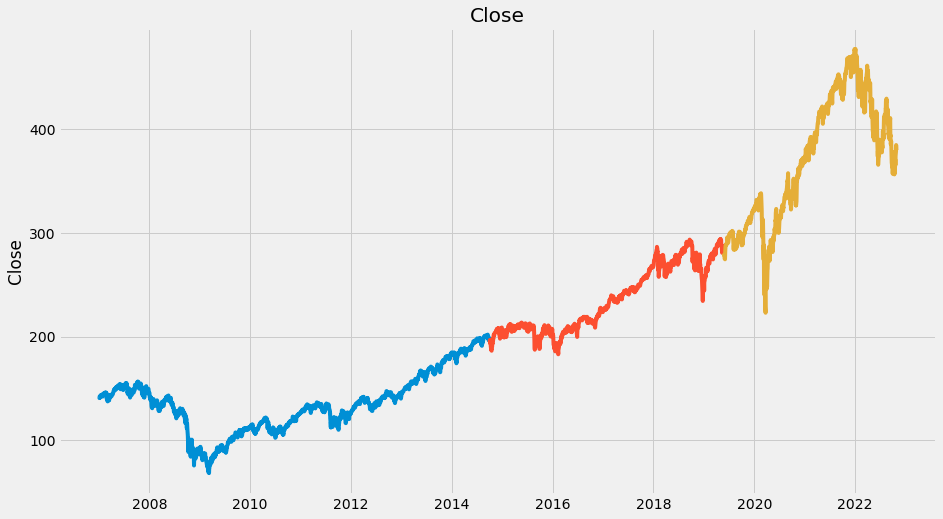

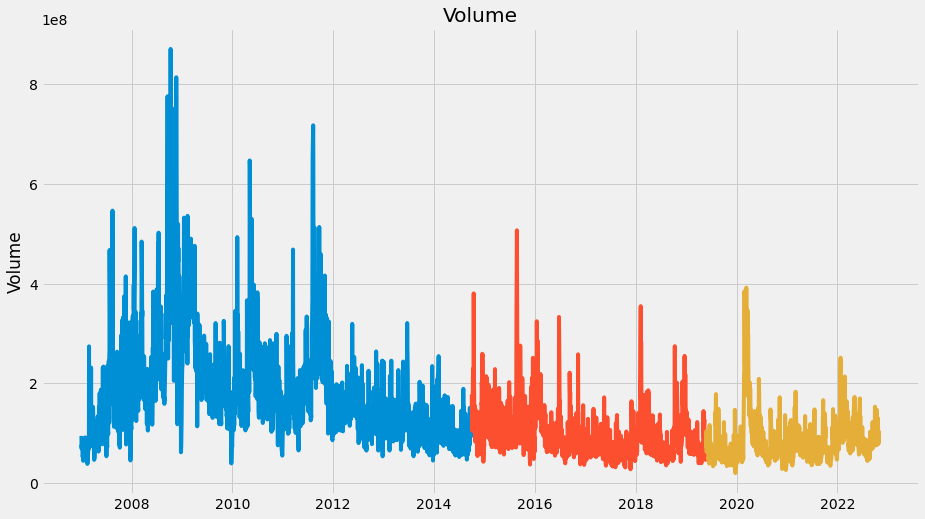

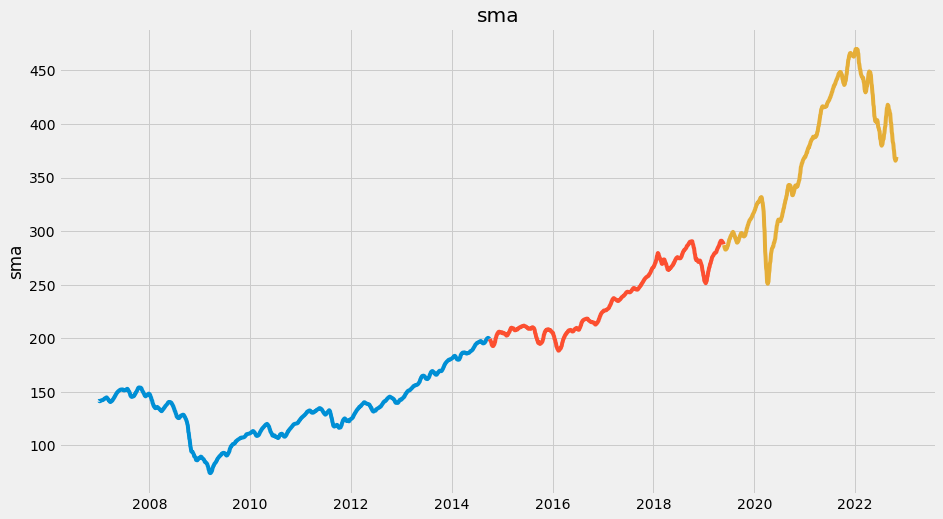

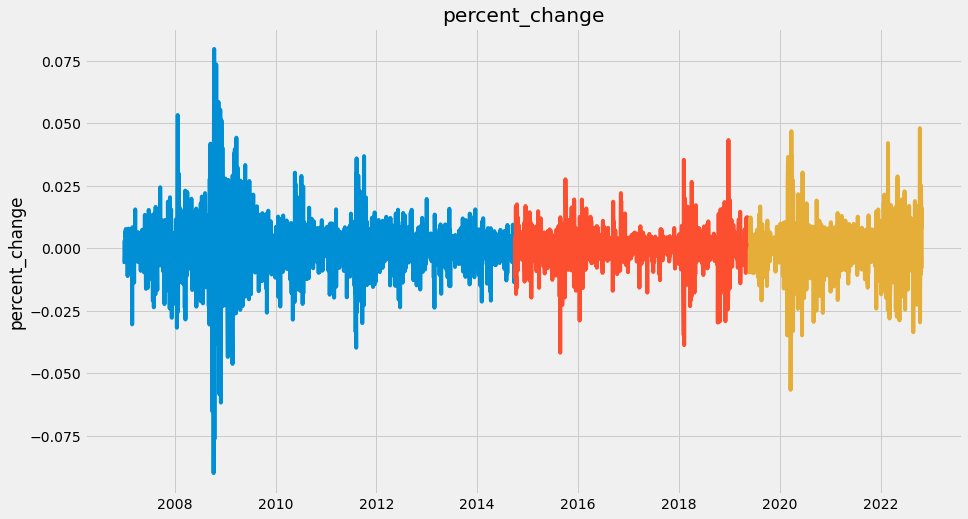

In [5]:
#visualizing stock chart with the different splits (Train, Validate and Test)
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Visualizing SMA (simple moving average)

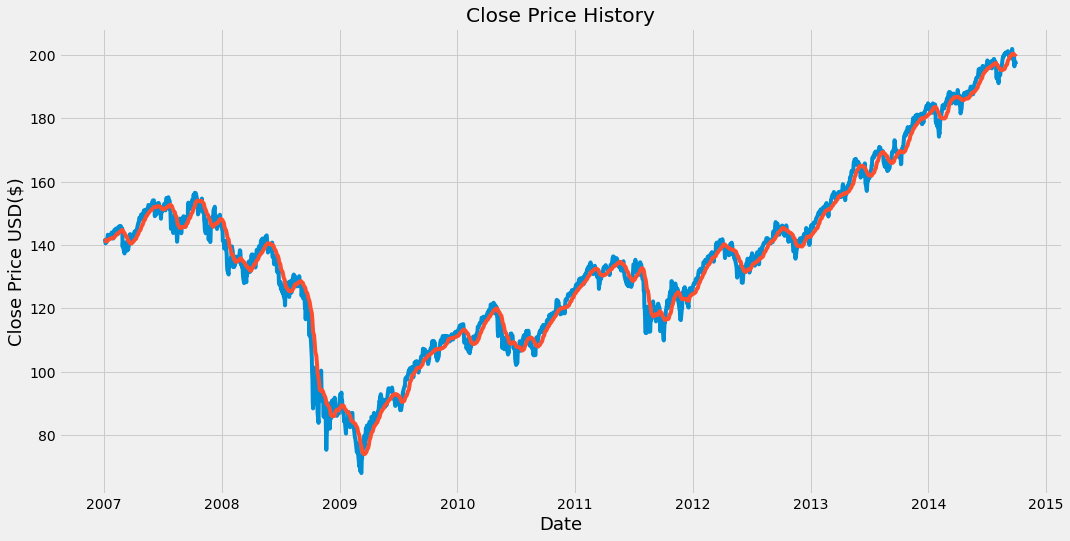

In [6]:
# visualize the S&P 500  data
plt.figure(figsize =(16,8))
plt.title("Close Price History")
plt.plot(train["Close"])
plt.plot(train["sma"])
# plt.plot(train["Volume"])
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD($)", fontsize = 18)
plt.show()

## Visualizing price and volume looking for trends

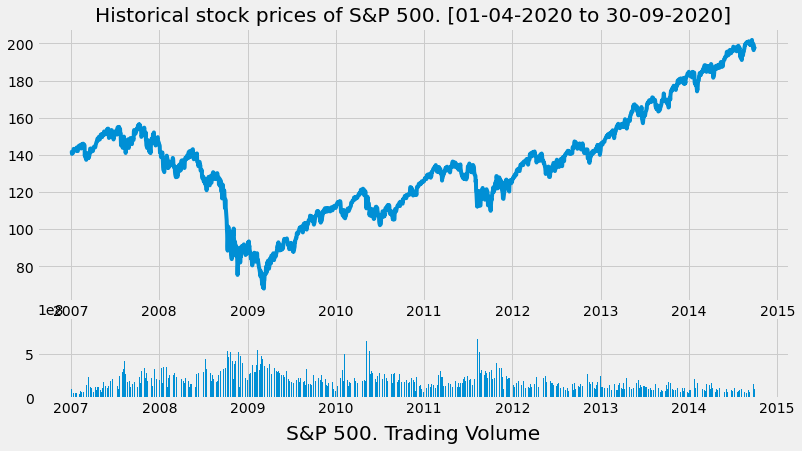

In [7]:
#visualizing volume and price
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(train.index, train["Close"])
plt.title('Historical stock prices of S&P 500. [01-04-2020 to 30-09-2020]')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(train.index, train['Volume'])
plt.title('\nS&P 500. Trading Volume', y=-0.60)
plt.gcf().set_size_inches(12,8)

In [8]:
def plot_volprice():
    #visualizing volume and price
    top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
    top_plt.plot(train.index, train["Close"])
    plt.title('Historical stock prices of S&P 500. [01-04-2020 to 30-09-2020]')
    bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
    bottom_plt.bar(train.index, train['Volume'])
    plt.title('\nS&P 500. Trading Volume', y=-0.60)
    return plt.gcf().set_size_inches(12,8)
    

## visualizing distributions of all the features

array([[<AxesSubplot:title={'center':'percent_change'}>]], dtype=object)

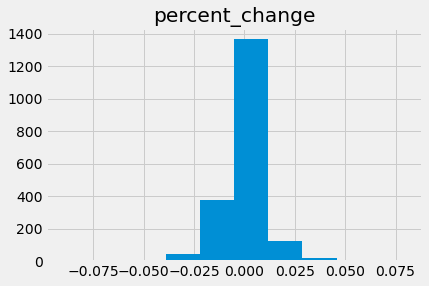

In [9]:
# plotting histograms to check distributions
plot_columns = train[["percent_change"]]
plot_columns.hist()

array([[<AxesSubplot:title={'center':'monthly_returns'}>]], dtype=object)

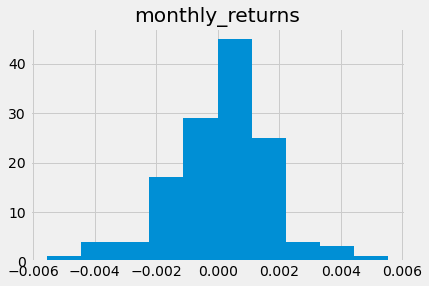

In [10]:
df["monthly_returns"] = df["percent_change"].resample(rule = "M").mean()
plot_col = df[["monthly_returns"]]
plot_col.hist()

## Takeaways
#### - it appears that the returns have a normal distrbution


---

## Visualizing monthly returns

[]

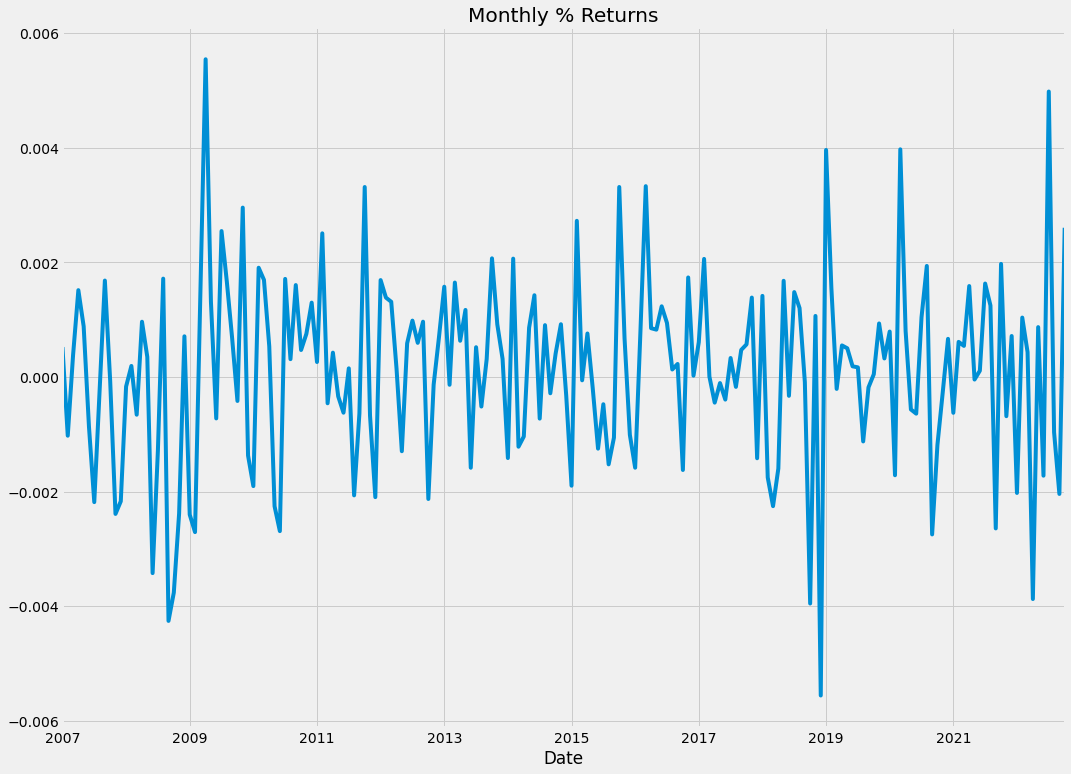

In [11]:
# visualizing  monthly returns 
df["percent_change"].resample(rule = "M").mean().plot(style= ["-"], figsize = (16,12))
plt.title("Monthly % Returns")
plt.plot()

<AxesSubplot:ylabel='Density'>

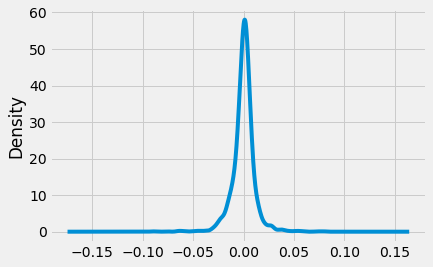

In [12]:
# stock market returns are generally in a daily normal  b
train.percent_change.plot(kind = "kde")

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

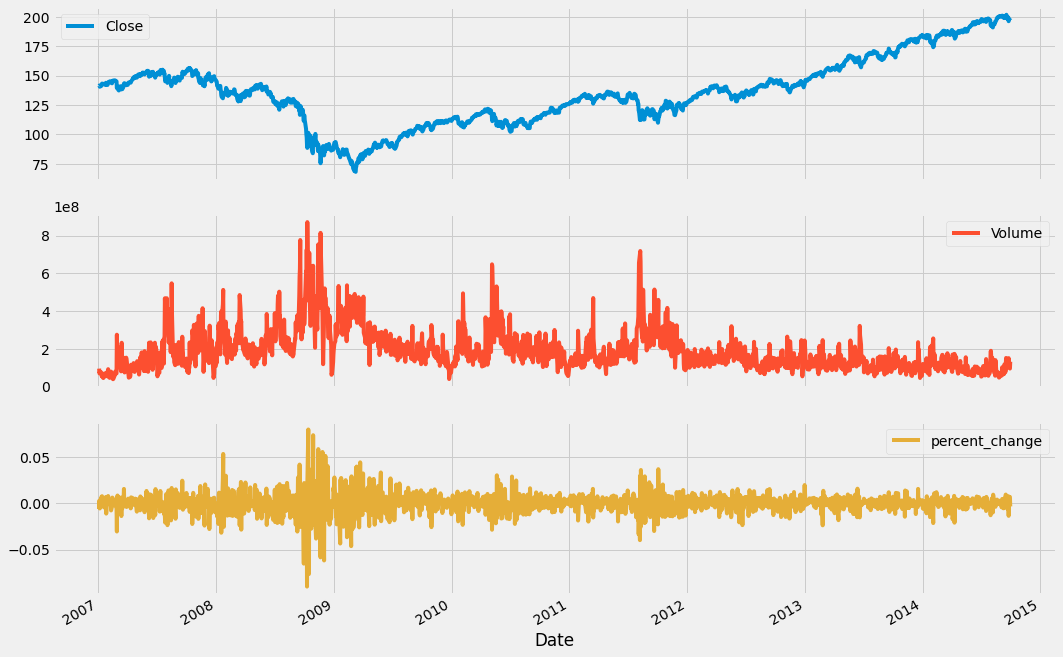

In [13]:
df_to_plot = train[["Close", "Volume","percent_change"]]
df_to_plot.plot(subplots = True, figsize = (16,12))

## Takeaways
#### - high volume is consistent with with volatility (high volatility comes with high volume)
#### - volume has been decreasing over the past years 
#### - daily percentage change  oscillates  between  -0.07 and 0.07

## Investigating the volume in relation to the price

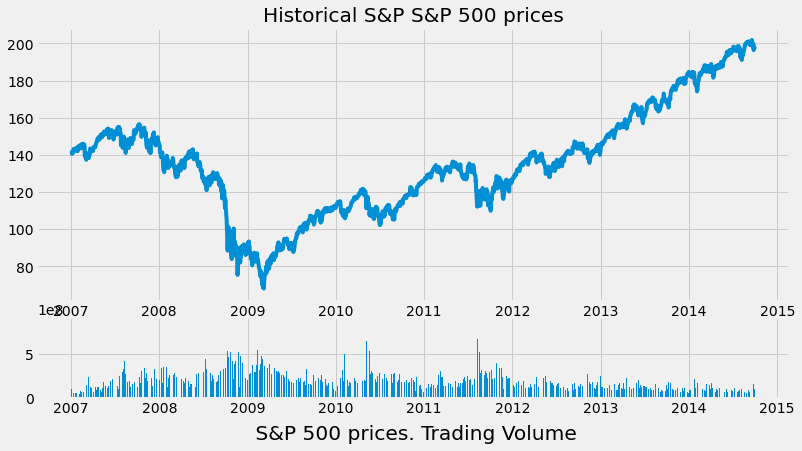

In [14]:
top_plt = plt.subplot2grid((5,4), (0, 0), rowspan=3, colspan=4)
top_plt.plot(train.index, train["Close"])
plt.title('Historical S&P S&P 500 prices')
bottom_plt = plt.subplot2grid((5,4), (3,0), rowspan=1, colspan=4)
bottom_plt.bar(train.index, train['Volume'])
plt.title('\n S&P 500 prices. Trading Volume', y=-0.60)
plt.gcf().set_size_inches(12,8)

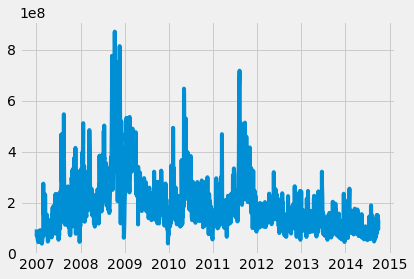

In [15]:
#plotting the volume 
plt.plot(train["Volume"])


[Text(0.5, 1.0, 'Monthly % Change in Price & Volume')]

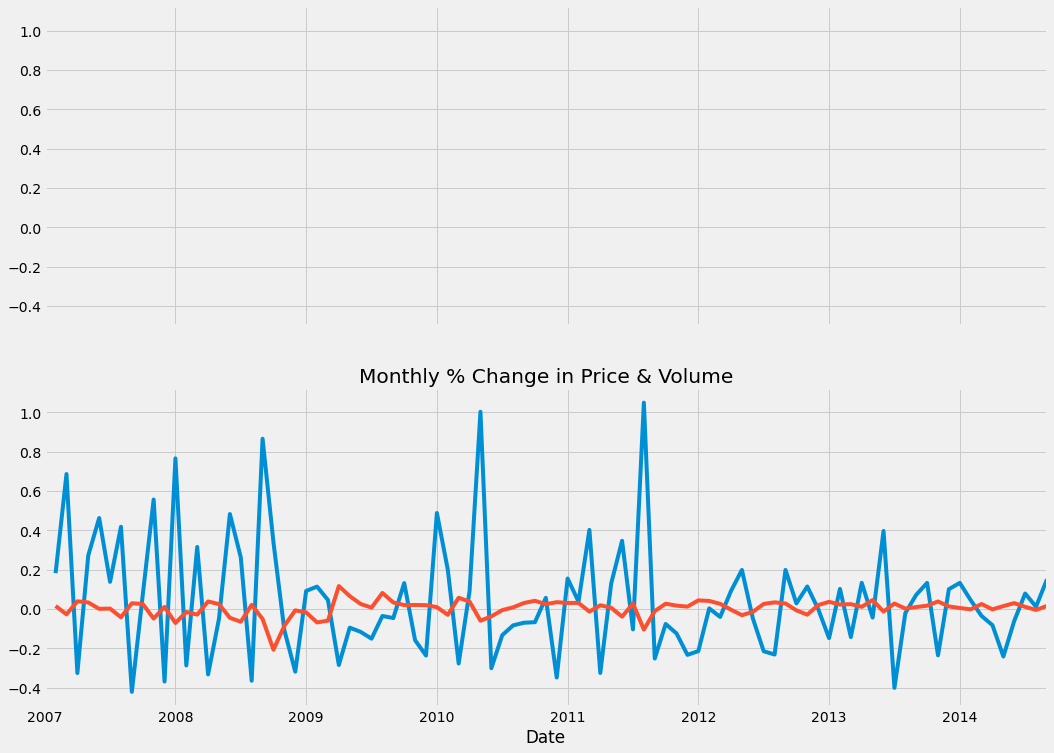

In [16]:
y1 = train.resample('D').Close.mean()
y = train.resample('D').Volume.mean()
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=True,figsize = (16,12))

monthly = y.resample('M').mean()
(monthly.diff() / monthly.shift()).plot(ax=ax2)
ax2.set(title='Monthly % Change in Volume')

monthly = y1.resample('M').mean()
(monthly.diff() / monthly.shift()).plot(ax=ax2)
ax2.set(title='Monthly % Change in Price & Volume')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

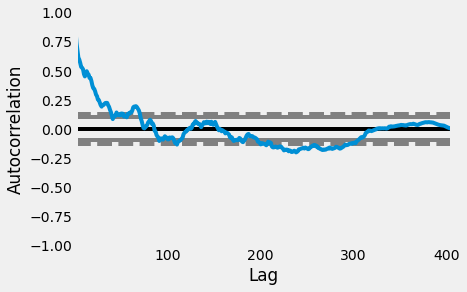

In [17]:
# Autocorrelation after weekly resampling:

pd.plotting.autocorrelation_plot(y.resample('W').mean())

### Box plotting the monthly volume

<AxesSubplot:xlabel='month', ylabel='Volume'>

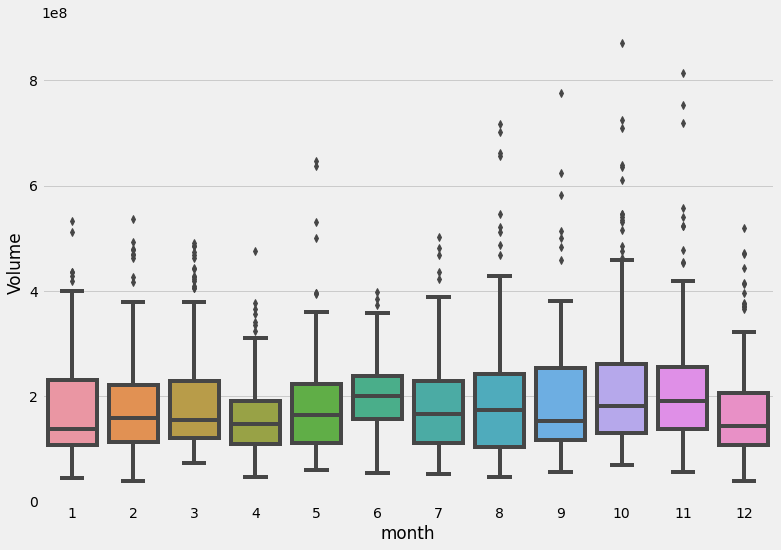

In [18]:
sizes = (11.7, 8.27)
train['month'] = train.index.month
fig, ax = pyplot.subplots(figsize=sizes)
sns.boxplot(data = train, x = 'month', y = 'Volume')



## Takeaways 
#### - Volume appears to decline over the years (consistent with companies conducting buybacks)
#### - Volume appears to be highest when volatility increases
#### - Volume declines in the summer months of June and July and picks up in August

# Scaling on the train set only

In [19]:
# convert df to np array
data = df.filter(["Close"])
dataset = data.values
# get number of rows to train
training_data_len = (len(train))
validate_data_len = (len(validate))
test_data_len = (len(test))
training_data_len, validate_data_len,test_data_len

(1950, 1170, 864)

In [20]:
#scale the data using a min max scaler 
scaler = MinMaxScaler(feature_range= (0,1))
scaled_data = scaler.fit_transform(dataset)


In [21]:
# create training data set 
# create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# split data into x and y train data
x_train = []
y_train = []
for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i, 0])
    if i <= 60:
        print(x_train)
        print(y_train)
        print()

[array([0.17885741, 0.17958984, 0.17683104, 0.17841798, 0.17812502,
       0.17927245, 0.18078614, 0.18342287, 0.18273928, 0.18288576,
       0.18171385, 0.18239748, 0.18132326, 0.18234864, 0.18515625,
       0.18103026, 0.18071291, 0.18051759, 0.1823242 , 0.18466797,
       0.18676758, 0.18725586, 0.18735353, 0.18745117, 0.18823244,
       0.18776857, 0.18513184, 0.18393554, 0.18688966, 0.18920899,
       0.18967286, 0.18950195, 0.19025878, 0.1901123 , 0.18984374,
       0.18845216, 0.18813476, 0.17429199, 0.17778319, 0.1767578 ,
       0.17226562, 0.16904299, 0.17478027, 0.17443847, 0.17731935,
       0.17741699, 0.1779297 , 0.17124024, 0.17375488, 0.17421876,
       0.17192383, 0.17600097, 0.17788086, 0.18354491, 0.18327635,
       0.18378906, 0.18332519, 0.18249512, 0.17995608, 0.18032227])]
[0.18039551035453774]



In [22]:
# convert x_and y_train dataset to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Modeling LSTM on the train set only

#### Data has to be reshaped  to 3 dimensions to allow LSTM model to be effective 

In [23]:
#reshape the data because LSTM expecting the data to be 3 diemsional
#ssamples timesets and features
x_train=np.reshape(x_train, (x_train.shape[0],60,1))
x_train.shape


(1890, 60, 1)

In [24]:
#preparing the model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

2022-11-01 16:56:00.873824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# compile the model( to measure how well the model did on training)
model.compile(optimizer = "adam", loss= "mean_squared_error")

In [26]:
# train the model, epoch is number of itterations (lookup callbacks)
model.fit(x_train, y_train, batch_size=32,epochs = 10)

Epoch 1/10
60/60 [==============================] - 11s 76ms/step - loss: 0.0022
Epoch 2/10
60/60 [==============================] - 4s 62ms/step - loss: 6.4068e-05
Epoch 3/10
60/60 [==============================] - 4s 72ms/step - loss: 6.1629e-05
Epoch 4/10
60/60 [==============================] - 4s 67ms/step - loss: 6.0172e-05
Epoch 5/10
60/60 [==============================] - 4s 64ms/step - loss: 6.1836e-05
Epoch 6/10
60/60 [==============================] - 4s 64ms/step - loss: 5.8192e-05
Epoch 7/10
60/60 [==============================] - 4s 63ms/step - loss: 5.6831e-05
Epoch 8/10
60/60 [==============================] - 4s 61ms/step - loss: 5.8781e-05
Epoch 9/10
60/60 [==============================] - 4s 64ms/step - loss: 5.6506e-05
Epoch 10/10
60/60 [==============================] - 4s 72ms/step - loss: 5.4272e-05


In [27]:
# create the validate data set... 

validate_data=scaled_data[validate_data_len - 60:, :]

In [28]:
x_validate = []
y_validate = dataset[validate_data_len:, :]
for i in range (60,len(validate_data)):
    x_validate.append(validate_data[i-60: i, 0])

In [29]:
# convert data to numpy array
x_validate = np.array(x_validate)

In [30]:
# reshpe the data 
x_validate = np.reshape(x_validate,(x_validate.shape[0], x_validate.shape[1],1))

In [31]:
# get models predicted price values same values as y_test
predictions = model.predict(x_validate)
predictions = scaler.inverse_transform(predictions)

88/88 [==============================] - 3s 18ms/step


In [32]:
# get the RMSE (root mean squared error)
rmse = np.sqrt(np.mean(predictions - y_validate)**2)
rmse

1.4809038179854426

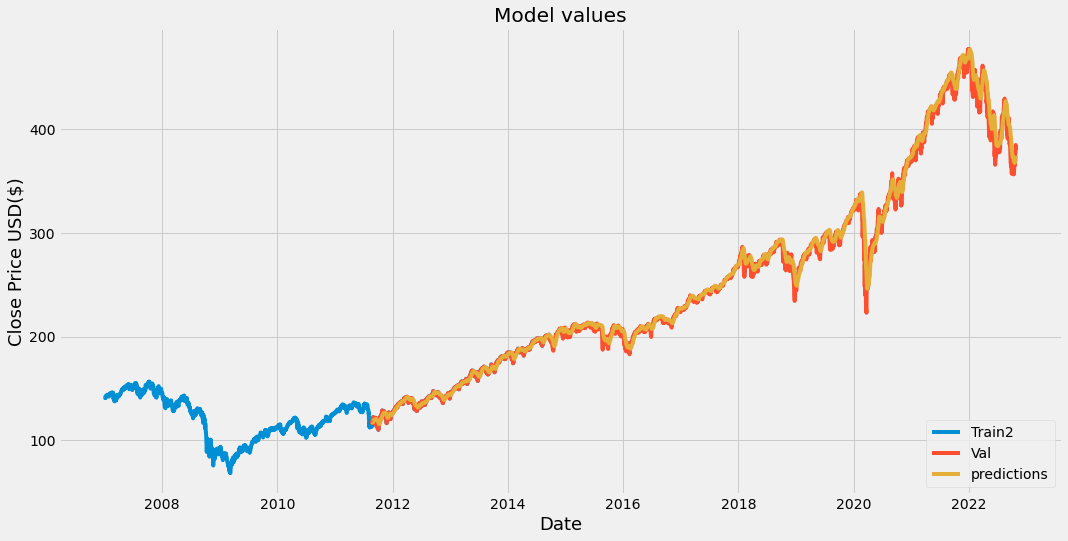

In [33]:
# plot the returns 
train2 = data[:training_data_len]
valid = data[validate_data_len:]
valid['predictions']= predictions
plt.figure(figsize=(16,8))
plt.title("Model values")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD($)", fontsize =18)
plt.plot(train2["Close"])
plt.plot(valid[["Close", "predictions"]])
plt.plot()
plt.legend(["Train2", "Val","predictions"], loc = "lower right")
plt.show()

-----

In [34]:
# create the testing data set... 
# create new array containing scaled values from index to 1199 to 2003
test_data=scaled_data[test_data_len - 60:, :]

In [35]:
# create the dataset x_test and y_test
x_test = []
y_test = dataset[test_data_len:, :]
for i in range (60,len(test_data)):
    x_test.append(test_data[i-60: i, 0])
    

In [36]:
# convert data to numpy array
x_test = np.array(x_test)

In [37]:
# reshpe the data 
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

In [38]:
# get models predicted price values same values as y_test
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

98/98 [==============================] - 2s 18ms/step


In [39]:
# get the RMSE (root mean squared error)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.4072354096632738

## Takeaways 
#### - The RMSE is at 32 cts prediction error with the test 

----

## Visualizing the model returns 

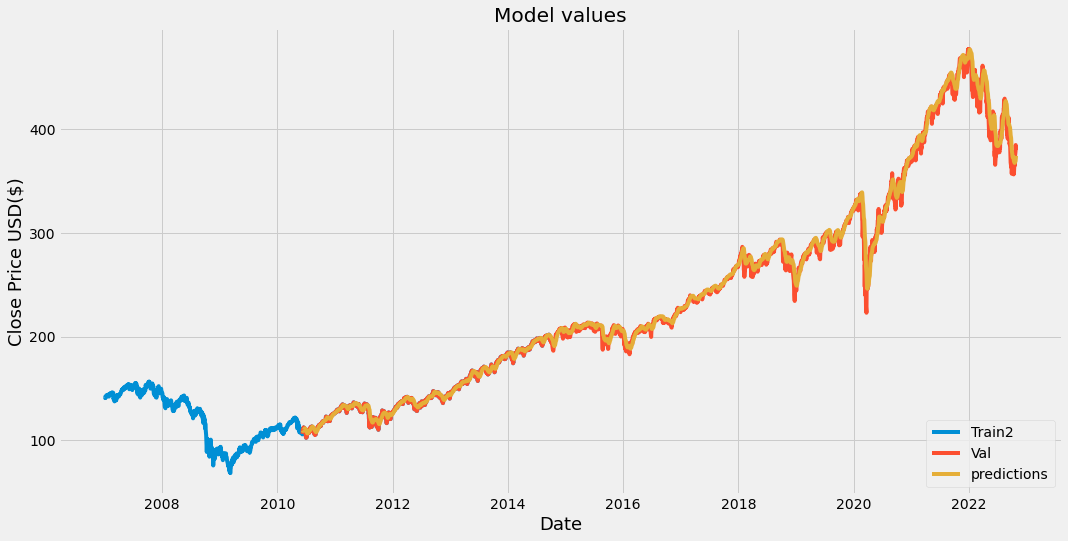

In [40]:
# plot the returns 
train2 = data[:training_data_len]
valid = data[test_data_len:]
valid['predictions']= predictions
plt.figure(figsize=(16,8))
plt.title("Model values")
plt.xlabel("Date", fontsize = 18)
plt.ylabel("Close Price USD($)", fontsize =18)
plt.plot(train2["Close"])
plt.plot(valid[["Close", "predictions"]])
plt.plot()
plt.legend(["Train2", "Val","predictions"], loc = "lower right")
plt.show()

# Testing the model
## Testing with recent data 

In [42]:
# predict price for a certaindate
spy_quote = pdr.DataReader("SPY", data_source = "yahoo", start= "2007-01-01", end = "2022-10-27")
# create new dataframe
new_df= spy_quote.filter(["Close"])
# get last 60 days closing price and convert df to array
last_60_days = new_df[-60:].values
# scale data to minmax scaler
last_60_days_scaled = scaler.transform(last_60_days)
# create empty list
X_test =[]
# append last 60 days
X_test.append(last_60_days_scaled)
# convert X_test data set to a np array
X_test = np.array(X_test)
# reshape data
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
# get the predicted price scaled
pred_price = model.predict(X_test)
# undo the scaling
pred_price = scaler.inverse_transform(pred_price)

print(pred_price)


1/1 [==============================] - 0s 77ms/step
[[376.36362]]


In [43]:
spy_quote_actual = pdr.DataReader("SPY", data_source = "yahoo", start= "2022-10-27", end = "2022-10-27")
spy_sma = train["sma"] =train ["Close"].rolling(window = 20, min_periods =1).mean()

print(spy_quote_actual["Close"])


Date
2022-10-27    379.980011
Name: Close, dtype: float64


----

# Conclusion

#### - Stock prices are extremely complicated to predict. There are many factors that can affect a stock price. However, having a model possibly predict the price with a low RMSE can help mitigate risk.
#### - Having a way to include macro economic factors is key. Possibly using a logistic regression model. 
#### - Key findings in returns show a normal distribution, therefore there can be other methods to predict the returns


## Recommendaton

####  This model will accurately provide the range of values that the stock has high probability of trading in. Example if model prediction is 180 with rmse of 5 then there is 68% chance that it will close between 175 - 185 range, and there is 95% chance that it will close between 170 - 190 range given that stock returns are randomly distributed and it follows standard normal distribution. If someone knows the range maybe they can wait for the stock to hit either high or low before taking trade or they can deploy option strategies based on the information they got from the model

## The "Empirical Rule" AKA "Three Sigma Rule" AKA 68–95–99.7 Rule
### Assumes a normal distribution of the observed variable
### Asserts that:
#### 68% of observations are within 1 standard deviation of the mean
#### 95% of observations are within 2 standard deviations of the mean
#### 99.7% of observations are within 3 standard deviations of the mean
#### Is often used as a quick test for normality
#### Is often erroneously applied to non-normally distributed data.
Can be an oversimplified approach